In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# 网络的定义,这样写是为了方便调超参数,函数里可以设置参数,这样就可以返回不同超参数的模型
def get_net(p1 = 0, p2 = 0):

    net = nn.Sequential(
        nn.Conv2d(1, 96, kernel_size = 11, stride = 4, padding = 1), nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.Conv2d(96, 256, kernel_size = 5, padding = 2), nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.Conv2d(256, 384, kernel_size = 3, padding = 1), nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size = 3, padding = 1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size = 3, padding = 1), nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2), nn.Flatten(),
        nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p = p1),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p = p2),
        nn.Linear(4096, 10)
#         , nn.Softmax(dim = 1)
    )

    return net

In [3]:
# dataset
resize_to_224 = transforms.Resize(224)
image_to_tensor = transforms.ToTensor()
transform = transforms.Compose((resize_to_224, image_to_tensor))
train_data_set = torchvision.datasets.FashionMNIST('data', train = True, transform = transform, download = True)
test_data_set = torchvision.datasets.FashionMNIST('data', train = False, transform = transform, download = True)

In [4]:
# dataloader
batch_size = 128
train_data_loader = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_data_loader = DataLoader(test_data_set, batch_size = batch_size, shuffle = False)

In [5]:
def accuracy_count(y_hat, y):
    predict = torch.argmax(y_hat, dim = 1)
    count = (predict == y).float()
    return count.sum().item()

def init_weight(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [6]:
def train(net, train_loader, test_loader, num_epochs, lr):

    # 初始化网络权重,将网络移动到gpu上
    net.apply(init_weight)
    net.to(torch.device('cuda'))

    # 定义loss和updater
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr = lr)

    # 动画
    animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs], legend = ['train_loss', 'train_acc', 'test_acc'])

    #训练和测试数据
    for epoch in range(num_epochs):

        # 三个累加器,分别代表训练损失,训练精度,测试精度
        train_loss = d2l.Accumulator(2)
        train_acc = d2l.Accumulator(2)
        test_acc = d2l.Accumulator(2)

        # 训练
        for x, y in train_loader:

            x = x.to(torch.device('cuda'))
            y = y.to(torch.device('cuda'))

            updater.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y)
            l.backward()
            updater.step()

            # 式子中带有w,但不是loss,即不参与梯度计算,都需要加torch.no_grad()
            with torch.no_grad():

                train_accuracy_count = accuracy_count(y_hat, y)

                train_loss.add(l, l.numel())
                train_acc.add(train_accuracy_count, y.numel())

        # 测试
        for x, y in test_loader:

            with torch.no_grad():

                x = x.to(torch.device('cuda'))
                y = y.to(torch.device('cuda'))

                y_hat = net(x)
                test_accuracy_count = accuracy_count(y_hat, y)

                test_acc.add(test_accuracy_count, y.numel())

        epoch_train_loss = train_loss[0] / train_loss[1]
        epoch_train_acc = train_acc[0] / train_acc[1]
        epoch_test_acc = test_acc[0] / test_acc[1]

        animator.add(epoch + 1, (epoch_train_loss, epoch_train_acc, epoch_test_acc))

    # 返回最后一个epoch跑完后的损失和精度,也即训练结束后的损失和精度
    return epoch_train_loss, epoch_train_acc, epoch_test_acc

In [7]:
lr, num_epochs = 0.01, 10

train_loss: 1.211560382009315
train_acc 0.5512666666666667
test_acc 0.7249


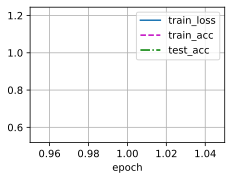

In [8]:
net = get_net(0.2, 0.5)
train_loss, train_acc, test_acc = train(net, train_data_loader, test_data_loader, num_epochs, lr)
print('train_loss:', train_loss)
print('train_acc', train_acc)
print('test_acc', test_acc)